# Flattening echelle spectra
Often-times, the model spectrum is just not good enough to get an adequate fit using the normal Fitters.RVFitter. When that is the case, the automated flattening just doesn't work. Let's give this a shot without using models. The thing we want to minimize is the offset between the flux at one order and the flux in the adjacent order. 

$$L = \sum_{i=1}^{N_{orders}-1} \left(\frac{O_i(\lambda)}{M(i, \lambda| \Theta)} - \frac{O_{i+1}(\lambda)}{M(i+1, \lambda | \theta)}\right)^2 $$ 

Where $M(i, \lambda | \theta)$ is perhaps a 2d polynomial function of some order where $i$ is for the order number, $\lambda$ is the wavelength (or maybe pixel number?), and the $\theta$ are all the polynomial coefficients.

# TRY:
  Try using Robust Linear Models from statsmodels. That might help it to ignore the big Balmer line. I will need to put the Chebyshev factors into a feature vector to use this...
  
  Those might help a bit. How about a hybrid approach where I divide by a stellar model (or empirical spectrum of similar type as Adam suggests), and then do a full robust 2D fit.
  
# Robust linear models works well enough for me!
I was able to sufficiently flatten a few of my spectra to get RV fits. I need to calibrate the RV though, so pretty much need to flatten every spectrum and fit the RV. This will take a while...

In [20]:
import SpecFlattener
import glob
import StarData
from astropy.io import fits
import SpectralTypeRelations
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [39]:
hdf5_lib = '/media/ExtraSpace/Kurucz_FullGrid/CHIRON_grid_full.hdf5'
star_list = [f for f in glob.glob('../201*/H*.fits') if 'smoothed' not in f and 'uncorrected' not in f and 'flattened' not in f]
print(len(star_list))
star_list.index('../20131019/HIP_22913.fits')

215


18

In [18]:
# Guess stellar properties
MS = SpectralTypeRelations.MainSequence()
def guess_teff_logg(fname):
    header = fits.getheader(fname)
    data = StarData.GetData(header['OBJECT'])
    spt = data.spectype
    teff = MS.Interpolate('Temperature', spt)
    logg = 3.5 if 'I' in spt else 4.0
    return teff, logg

In [ ]:
# Loop over each of the files in star_list, flattening each one.
reload(SpecFlattener)
for filename in star_list[18:]:
    print('\n\n{}'.format(filename))
    teff, logg = guess_teff_logg(filename)
    flattened = SpecFlattener.flatten_spec(filename, hdf5_lib, teff=teff, logg=logg, normalize_model=False)



../20131019/HIP_22913.fits
This file has previously been fit. Do you want to re-fit? y/[N]: n


INFO:root:Initializing continuum for RV guess.
INFO:root:Estimating the RV and vsini by cross-correlation
INFO:root:Flattening the spectrum using the best-fit values


In [27]:
header = fits.getheader(star_list[0])
print star_list[0], header['OBJECT'], header['DATE-OBS']

../20140514/HIP_85537.fits HIP 85537 2014-05-15T05:30:13.7


In [36]:
import h5py
f = h5py.File(hdf5_lib, 'r')
print(f['flux'].keys())
f.close()

[u't10000g3.0z-0.5a0.0', u't10000g3.0z-0.5a0.4', u't10000g3.0z0.0a0.0', u't10000g3.0z0.0a0.4', u't10000g3.0z0.5a0.0', u't10000g3.0z0.5a0.4', u't10000g3.5z-0.5a0.0', u't10000g3.5z-0.5a0.4', u't10000g3.5z0.0a0.0', u't10000g3.5z0.0a0.4', u't10000g3.5z0.5a0.0', u't10000g3.5z0.5a0.4', u't10000g4.0z-0.5a0.0', u't10000g4.0z-0.5a0.4', u't10000g4.0z0.0a0.0', u't10000g4.0z0.0a0.4', u't10000g4.0z0.5a0.0', u't10000g4.0z0.5a0.4', u't10000g4.5z-0.5a0.0', u't10000g4.5z-0.5a0.4', u't10000g4.5z0.0a0.0', u't10000g4.5z0.0a0.4', u't10000g4.5z0.5a0.0', u't10000g4.5z0.5a0.4', u't10000g5.0z-0.5a0.0', u't10000g5.0z-0.5a0.4', u't10000g5.0z0.0a0.0', u't10000g5.0z0.0a0.4', u't10000g5.0z0.5a0.0', u't10000g5.0z0.5a0.4', u't10250g3.0z-0.5a0.0', u't10250g3.0z-0.5a0.4', u't10250g3.0z0.0a0.0', u't10250g3.0z0.0a0.4', u't10250g3.0z0.5a0.0', u't10250g3.0z0.5a0.4', u't10250g3.5z-0.5a0.0', u't10250g3.5z-0.5a0.4', u't10250g3.5z0.0a0.0', u't10250g3.5z0.0a0.4', u't10250g3.5z0.5a0.0', u't10250g3.5z0.5a0.4', u't10250g4.0z-0.5a0

<IPython.core.display.Javascript object>


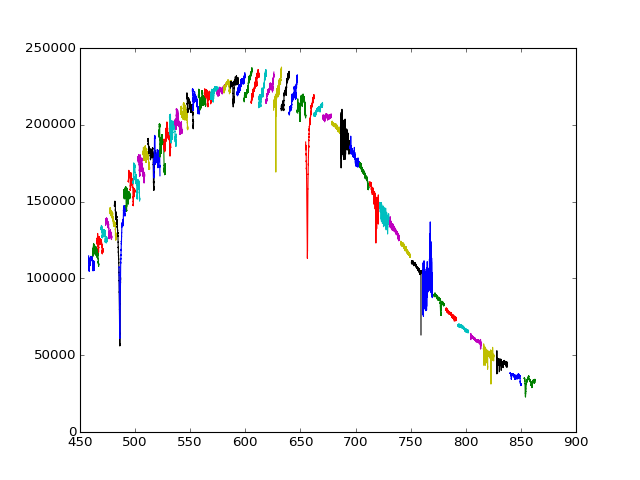

In [61]:
infilename = '../20140310/HIP_27100.fits'
orders = HelperFunctions.ReadExtensionFits(infilename)
%matplotlib notebook
for order in orders:
    plt.plot(order.x, order.y)

In [62]:
hdf5_lib = '/media/ExtraSpace/Kurucz_FullGrid/CHIRON_grid.hdf5'
x_degree = 4
y_degree = 9
logger.setLevel(logging.INFO)
reload(SpecFlattener)

mcf = SpecFlattener.ModelContinuumFitter(orders[:20], hdf5_lib, x_degree=x_degree, y_degree=y_degree,
                                         T=7425, logg=3.34, initialize=True)
print mcf.rv_guess, mcf.vsini_guess
teff, logg, rv = mcf.fit(teff=7425, logg=3.34)

INFO:root:Initializing continuum for RV guess.
INFO:root:Estimating the RV and vsini by cross-correlation


Determine Chunk Log: Wl is 131072
6.80191297249

INFO:root:T = 7425.0
logg = 3.34
RV = 6.80191297249
INFO:root:LogL = -717299.575246

INFO:root:T = 7425.1
logg = 3.34
RV = 6.80191297249
INFO:root:LogL = -717292.122794

INFO:root:T = 7425.0
logg = 3.44
RV = 6.80191297249
INFO:root:LogL = -719620.541847

INFO:root:T = 7425.0
logg = 3.34
RV = 6.90191297249
INFO:root:LogL = -717308.934377

INFO:root:T = 7499.5245179
logg = 3.0
RV = -86.7893996619
INFO:root:LogL = -2902159.08281

INFO:root:T = 7499.6245179
logg = 3.0
RV = -86.7893996619
INFO:root:LogL = -2902282.79865

INFO:root:T = 7499.5245179
logg = 3.1
RV = -86.7893996619
INFO:root:LogL = -2875429.13721

INFO:root:T = 7499.5245179
logg = 3.0
RV = -86.6893996619
INFO:root:LogL = -2897746.74984

INFO:root:T = 7425.36197475
logg = 3.33834857816
RV = 6.34732845073
INFO:root:LogL = -717294.549789

INFO:root:T = 7425.46197475
logg = 3.33834857816
RV = 6.34732845073
INFO:root:LogL = -717291.925417

INFO:root:T = 7425.36197475
logg = 3.43834857816
RV = 6.34732845073
INFO:root:LogL = -719440.6

 239.382203515


7425.36197475 3.33834857816 6.34732845073


<IPython.core.display.Javascript object>


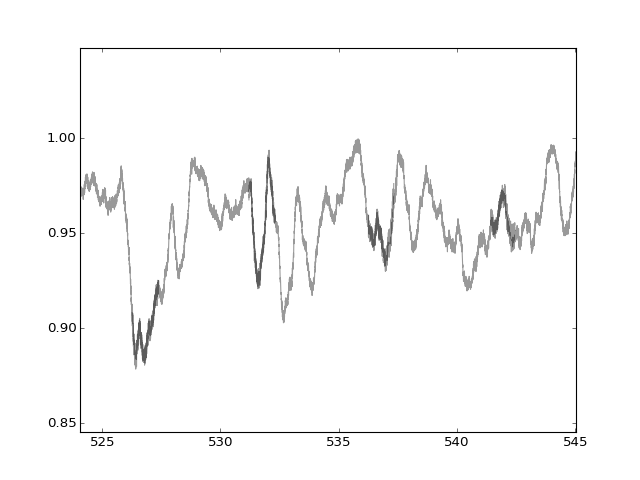

In [64]:
#teff, logg, rv = 9733, 3.47, 21.618
print teff, logg, rv
mcf.update_model(Teff=teff, logg=logg, feh=0.0)
p = (rv, mcf.vsini_guess)
flattened = mcf.flatten_orders(pars=p, plot=False, norm=norms.HuberT())
shifted_orders = mcf.shift_orders(flattened)

%matplotlib notebook
for order in shifted_orders:
    plt.plot(order.x, order.y, 'k-', alpha=0.4)

<IPython.core.display.Javascript object>


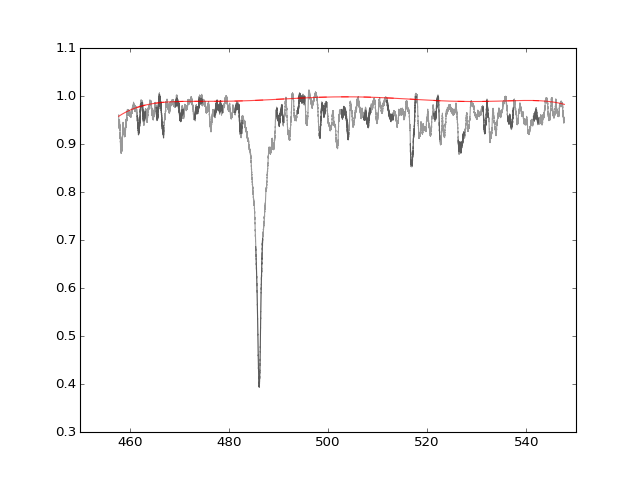

In [65]:
# Fit a continuum to the whole thing
x = np.hstack([o.x for o in shifted_orders])
y = np.hstack([o.y for o in shifted_orders])

def continuum(x, y, lowreject=3, highreject=5, fitorder=3):
    done = False
    idx = (x < 480) | (x > 490)
    x2 = np.copy(x[idx])
    y2 = np.copy(y[idx])
    while not done:
        done = True
        pars = np.polyfit(x2, y2, fitorder)
        fit = np.poly1d(pars)
    
        residuals = y2 - fit(x2)
        mean = np.mean(residuals)
        std = np.std(residuals)
        badpoints = np.where(np.logical_or((residuals - mean) < -lowreject*std, residuals - mean > highreject*std))[0]
        if badpoints.size > 0 and x2.size - badpoints.size > 5*fitorder:
            done = False
            x2 = np.delete(x2, badpoints)
            y2 = np.delete(y2, badpoints)
    return np.poly1d(pars)
    

#cont = FittingUtilities.Continuum(x, y, lowreject=2, highreject=8, fitorder=5)
#contfcn = spline(x, cont)
contfcn = continuum(x, y, lowreject=1.5, highreject=20, fitorder=6)


%matplotlib notebook
renormalized = []
for order in shifted_orders:
    cont = contfcn(order.x)
    plt.plot(order.x, order.y, 'k-', alpha=0.4)
    plt.plot(order.x, cont, 'r-', alpha=0.7)
    o = order.copy()
    o.y /= cont
    renormalized.append(o.copy())
    

In [66]:
# Output to file
column_dicts = []
for order in renormalized:
    column_dicts.append(dict(wavelength=order.x, error=order.err, continuum=np.ones(order.size()), flux=order.y))
    
outfilename = '{}_flattened.fits'.format(infilename.split('.fits')[0])
HelperFunctions.OutputFitsFileExtensions(column_dicts, infilename, outfilename, mode='new')